In [150]:
%matplotlib notebook

In [151]:
from __future__ import print_function

In [206]:
import sys
import os
import shutil
import copy
import time
import imp
import json
import argparse
import traceback
import numpy as np
import matplotlib.pyplot as plt
import pymultinest as pmn
import corner


#-----------------------------------------------------------------------------#
def prior_call(priorTypes, bounds, values):
    """Returns a function to transform (0-1) range to the distribution of
    values for each parameter. Note that a numpy vectorised version of this
    function fails because of type-errors."""

    def prior(p, nDim, nParms):
        for i in range(nDim):
            if priorTypes[i] == "log":
                bMin = np.log(np.abs(bounds[i][0]))
                bMax = np.log(np.abs(bounds[i][1]))
                p[i] *= bMax - bMin
                p[i] += bMin
                p[i] = np.exp(p[i])
            elif priorTypes[i] == "normal":
                bMin, bMax = bounds[i]
                sigma = (bMax - bMin)/2.0
                mu = bMin + sigma
                p[i] = mu + sigma * ndtri(p[i])
            elif priorTypes[i] == "fixed":
                p[i] = values[i]
            else: # uniform (linear)
                bMin, bMax = bounds[i]
                p[i] = bMin + p[i] * (bMax - bMin)
        return p

    return prior


#-----------------------------------------------------------------------------#
def lnlike_call(parNames, x, y, dy):
    """ Returns a function to evaluate the log-likelihood """

    def lnlike(p, nDim, nParms):

        # Evaluate the model and calculate the joint ln(like)
        # Silva 2006
        pDict = {k:v for k, v in zip(parNames, p)}
        ymod = model(pDict, x)
        chiSq = np.nansum(np.power((y-ymod)/dy, 2))
        nData = len(x)
        logLike = -chiSq

        return logLike

    return lnlike


#-----------------------------------------------------------------------------#
def chisq_model(parNames, p, x, y, dy):
    """Calculate the chi^2 for the current model, given the data."""

    # Evaluate the model and calculate chisq
    pDict = {k:v for k, v in zip(parNames, p)}
    ymod = model(pDict, x)
    chiSq = np.nansum(np.power((y-ymod)/dy, 2))

    return chiSq


#-----------------------------------------------------------------------------#
def wrap_chains(chains, wraps, bounds, p, verbose=False):

    # Get the indices of the periodic parameters
    iWrap = [i for i, e in enumerate(wraps) if e != 0]

    # Loop through the chains for periodic parameters
    for i in iWrap:
        wrapLow = bounds[i][0]
        wrapHigh = bounds[i][1]
        rng = wrapHigh - wrapLow

        # Shift the wrapping to centre on the best fit value
        wrapCent = wrapLow + (wrapHigh - wrapLow)/2.0
        wrapLow += (p[i] - wrapCent)
        wrapHigh += (p[i] - wrapCent)
        chains[:, i] = ((chains[:, i]-wrapLow) % rng) + wrapLow
        if verbose:
            print("Wrapped parameter '%d' in range [%s, %s] ..." %
                  (i, wrapLow, wrapHigh))

    return chains


#-----------------------------------------------------------------------------#
def init_mnest():
    """Initialise MultiNest arguments"""

    argsDict = {'LogLikelihood':              '',
                'Prior':                      '',
                'n_dims':                     0,
                'n_params':                   0,
                'n_clustering_params':        0,
                'wrapped_params':             None,
                'importance_nested_sampling': False,
                'multimodal':                 False,
                'const_efficiency_mode':      False,
                'n_live_points':              100,
                'evidence_tolerance':         0.5,
                'sampling_efficiency':        'model',
                'n_iter_before_update':       500,
                'null_log_evidence':          -1.e90,
                'max_modes':                  100,
                'mode_tolerance':             -1.e90,
                'outputfiles_basename':       '',
                'seed':                       -1,
                'verbose':                    True,
                'resume':                     True,
                'context':                    0,
                'write_output':               True,
                'log_zero':                   -1.e100,
                'max_iter':                   0,
                'init_MPI':                   False,
                'dump_callback':              None}
    return argsDict


#-----------------------------------------------------------------------------#
def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

#-----------------------------------------------------------------------------#

In [207]:
mod = imp.load_source("model","models/model.py")
global model
model = mod.model


# Unpack the inParms structure
parNames = [x["parname"] for x in mod.inParms]
labels = [x["label"] for x in mod.inParms]
values = [x["value"] for x in mod.inParms]
bounds = [x["bounds"] for x in mod.inParms]
priorTypes = [x["priortype"] for x in mod.inParms]
wraps = [x["wrap"] for x in mod.inParms]
nDim = len(priorTypes)
fixedMsk = [0 if x=="fixed" else 1 for x in priorTypes]
nFree = sum(fixedMsk)
# Set the prior function given the bounds of each parameter
prior = prior_call(priorTypes, bounds, values)

<IPython.core.display.Javascript object>


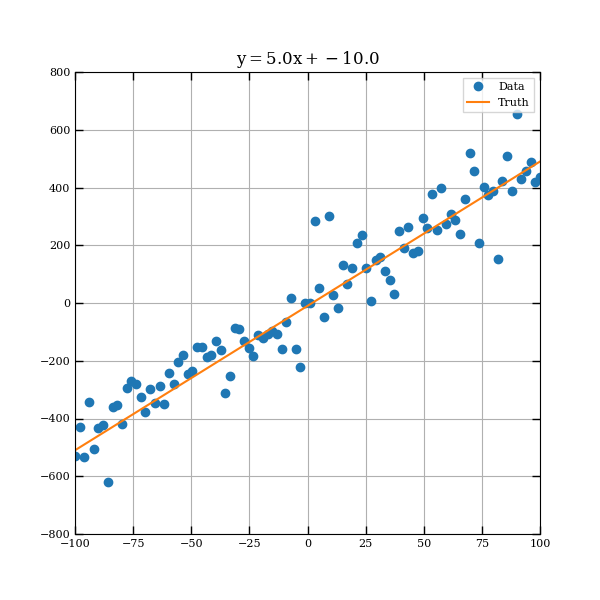

In [239]:
# Make some fake data
x = np.linspace(-100, 100, 100)

m = 5
c = -10

y_true = m*x +c

noise = np.random.normal(0,100,len(x))

y = y_true + noise

dy = np.ones_like(y)*(100)

plt.figure()
plt.plot(x, y, 'o', label = 'Data')
plt.plot(x, y_true, label = 'Truth')
plt.title(r'$y = %0.1f'  %m + ' x + %0.1f' %c + ' $')
#plt.hlines(0, -100, 100, linestyles='--')
plt.grid()
plt.legend()

In [221]:
prefixOut, ext = os.path.splitext('/home/athomson/test')
nestOut = prefixOut + "_nest/"
if os.path.exists(nestOut):
        shutil.rmtree(nestOut, True)
os.mkdir(nestOut)

In [222]:
# Set the likelihood function given the data
lnlike = lnlike_call(parNames, x, y, dy)

# Run nested sampling using PyMultiNest
nestArgsDict = merge_two_dicts(init_mnest(), mod.nestArgsDict)
nestArgsDict["n_params"]             = nDim
nestArgsDict["n_dims"]               = nDim
nestArgsDict["outputfiles_basename"] = nestOut
nestArgsDict["LogLikelihood"]        = lnlike
nestArgsDict["Prior"]                = prior

In [223]:
pmn.run(**nestArgsDict)

In [224]:
# Query the analyser object for results
aObj = pmn.Analyzer(n_params=nDim, outputfiles_basename=nestOut, verbose=True)
statDict = aObj.get_stats()
fitDict = aObj.get_best_fit()

  analysing data from /home/athomson/test_nest/.txt


In [225]:
# NOTE: The Analyser methods do not work well for parameters with
# posteriors that overlap the wrap value. Use np.percentile instead.
pMed = [None]*nDim
for i in range(nDim):
    pMed[i] = statDict["marginals"][i]['median']
lnLike = fitDict["log_likelihood"]
lnEvidence = statDict["nested sampling global log-evidence"]
dLnEvidence = statDict["nested sampling global log-evidence error"]

In [226]:
# Get the best-fitting values & uncertainties directly from chains
chains =  aObj.get_equal_weighted_posterior()
chains = wrap_chains(chains, wraps, bounds, pMed)
p = [None]*nDim
errPlus = [None]*nDim
errMinus = [None]*nDim
g = lambda v: (v[1], v[2]-v[1], v[1]-v[0])
for i in range(nDim):
    p[i], errPlus[i], errMinus[i] = \
                g(np.percentile(chains[:, i], [15.72, 50, 84.27]))

In [227]:
# Calculate goodness-of-fit parameters
nData = len(x)
dof = nData - nFree -1
chiSq = chisq_model(parNames, p, x, y, dy)
chiSqRed = chiSq/dof
AIC = 2.0*nFree - 2.0 * lnLike
AICc = 2.0*nFree*(nFree+1)/(nData-nFree-1) - 2.0 * lnLike
BIC = nFree * np.log(nData) - 2.0 * lnLike

In [228]:
# Summary of run
print("")
print("-"*80)
print("SUMMARY OF SAMPLING RUN:")
print("DOF           = %d" % dof)
print("CHISQ:        = %.3g" % chiSq)
print("CHISQ RED     = %.3g" % chiSqRed)
print("AIC:          = %.3g" % AIC)
print("AICc          = %.3g" % AICc)
print("BIC           = %.3g" % BIC)
print("ln(EVIDENCE)  = %.3g" % lnEvidence)
print("dLn(EVIDENCE) = %.3g" % dLnEvidence)
print("")
print("-"*80)
print("RESULTS:\n")
for i in range(len(p)):
    print("%s = %.4g (+%3g, -%3g)" % \
          (parNames[i], p[i], errPlus[i], errMinus[i]))
    print("-"*80)
    print("")


--------------------------------------------------------------------------------
SUMMARY OF SAMPLING RUN:
DOF           = 97
CHISQ:        = 97.5
CHISQ RED     = 1.01
AIC:          = 199
AICc          = 195
BIC           = 204
ln(EVIDENCE)  = -108
dLn(EVIDENCE) = 0.098

--------------------------------------------------------------------------------
RESULTS:

m = 5.113 (+0.120603, -0.119024)
--------------------------------------------------------------------------------

c = -19.92 (+7.14023, -7.08341)
--------------------------------------------------------------------------------



<IPython.core.display.Javascript object>


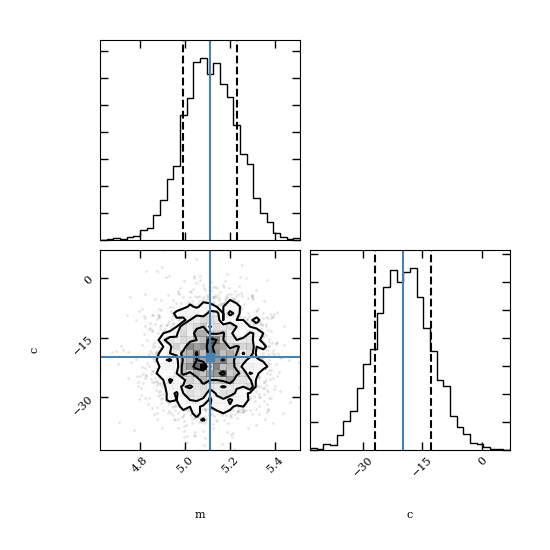

In [229]:
# Plot the posterior samples in a corner plot
chains =  aObj.get_equal_weighted_posterior()
chains = wrap_chains(chains, wraps, bounds, p)[:, :nDim]
iFixed = [i for i, e in enumerate(fixedMsk) if e==0]
chains = np.delete(chains, iFixed, 1)
for i in sorted(iFixed, reverse=True):
    del(labels[i])
    del(p[i])
cornerFig = corner.corner(xs      = chains,
                          labels  = labels,
                          range   = [0.99999]*nFree,
                          truths  = p,
                          quantiles = [0.1572, 0.8427],
                          bins    = 30)

In [230]:
pDict = {k:v for k, v in zip(parNames, p)}
errpDict = {k:v for k, v in zip(parNames, errPlus)}
for k in errpDict:
    errpDict[k] = pDict[k] + errpDict[k]

errmDict = {k:v for k, v in zip(parNames, errMinus)}


for k in errpDict:
    errmDict[k] = pDict[k] - errmDict[k]
    
y_mod = model(pDict, x)
y_errp = model(errpDict, x)
y_errm = model(errmDict, x)

<IPython.core.display.Javascript object>


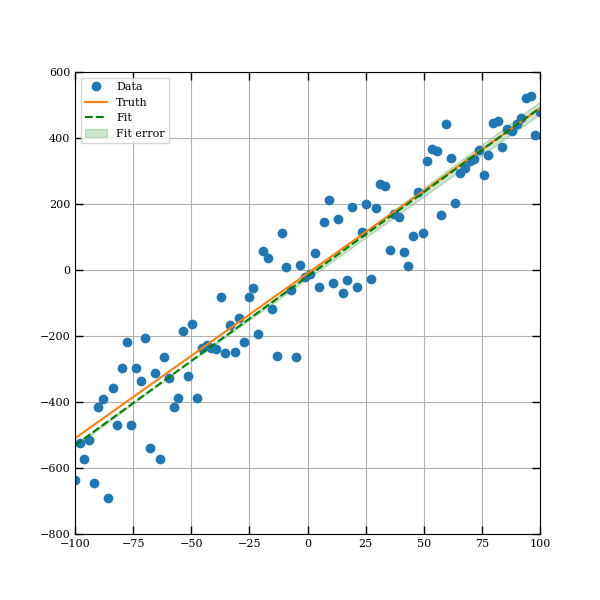

In [231]:
plt.figure()
plt.plot(x, y, 'o', label = 'Data')
plt.plot(x, y_true, label = 'Truth')
plt.plot(x, y_mod, 'g--', label = 'Fit')
plt.fill_between(x, y_errm, y_errp, color='g', label = 'Fit error', alpha = 0.2)
#plt.hlines(0, -100, 100, linestyles='--')
plt.grid()
plt.legend()